# Topic Modeling (Latent Dirichlet Allocation)

Для тематического моделирования было принято решение попробовать применить метод LDA: латентное размещение Дирихле или Latent Dirichlet Allocation (согласно пакету scikit-learn). 

Данный метод относится к вероятностным подходам, включает в себя возможности определения топика через популярные термы (слова), является популярным в направлении NLP, а также имеет реализацию
online-обучения по batch-ам.

Датасет из текстов имеет больше 5 млн. текстов, а вычисления производились на удалённой машине с вызовом нескольких процессов, поэтому в данная jupyter-тетрадка выступает в качестве обобщения результата.

В данной тетрадке следующие слова взаимозаменяемы:

    1. слово, терм
    2. LDA, Latent Dirichlet Allocation

In [28]:
import re
import json
import timeit
import pickle
from collections import Counter
from pprint import pprint

import ujson
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import LatentDirichletAllocation as LDA

Данных много, поэтому предобработка и удаления (даже на уровне удаления ненужных полей) велась итерационно. Например:

In [ ]:
def preprocess_word(word: str) -> str:
    """
    Preprocess word

    :param word: word

    :return: cleaning word
    """
    
    regex_spec_symbol = re.compile(r'[\.\,\?\!\(\)\/\$\{\}\[\]\@\^]+')  # это временная реализация для введения
    regex_spec_symbol_to_space = re.compile(r'[\“\"\']+')               # ниже будет представлен класс для
    regex_multi_space_to_space = re.compile(r'\s+')                     # продового решения

    word_new = regex_spec_symbol.sub('', word.lower())
    word_new = regex_spec_symbol_to_space.sub(' ', word_new)
    word_new = regex_multi_space_to_space.sub(' ', word_new)

    return word_new


PATH_RAW_DATA = 'dblpv13.jsonl'
PATH_CLEAN_DATA = 'dblpv13_en_clean.jsonl'

with open(PATH, 'r', encoding='utf-8') as fio, open(PATH_CLEAN_DATA, 'w', encoding='utf-8') as fio_clean:
    for line in tqdm(fio):
        dict_line = ujson.loads(line)

        title: str = dict_line.get('abstract', '')
        abstract: str = dict_line.get('title', '')

        if len(title) > 0 and len(abstract) > 0:
            if title.lower() in abstract.lower():
                text = abstract
            elif abstract.lower() in title.lower():
                text = title
            else:
                text = title + ' ' + abstract
        else:
            text = title + ' ' + abstract

        collect_word = text.split()

        if len(collect_word) <= 3:
            continue

        text = ' '.join(map(preprocess_word, collect_word))

        dict_line_new = {'_id': dict_line['_id'], 'text': text}

        fio_clean.write(json.dumps(dict_line_new) + '\n')

В основе LDA чаще всего используется с мешком слов (bag of words), иначе сильно падает интерпретируемость, например, матрицы (topic x word), которая популярна для интерпретации самих тематик текстов.

Также важно понимать, что первым делом всегда лучше начинать с базовых или простых подходов. В данном случае выбрана простая связка как CounterVectorizer (мешок слов) и LDA. CounterVectorizer написан вручную, т.к. обычный из scikit-learn-а учится сразу на всём корпусе, а использовать какие-то тяжёловесные (в том числе по зависимостям) вещи из других пакетов для обычного baseline, возможно, не лучшая идея. Субъективно, но так.

Т.к. тексты много, то аналогичным (выше) способом собирается различная статистика и сохраняется в отдельные файлы для дальнейшего анализа. Пример абсолютного счётчика слов во всём корпусе текстов:

In [ ]:
data = []
counter_data = Counter()

with open(PATH_CLEAN_DATA, 'r', encoding='utf-8') as fio:
    for line in tqdm(fio):
        dict_line = ujson.loads(line)

        text = dict_line['text']

        counter_data += Counter(text.split())

with open('counter_all_word_clean_2.json', 'w', encoding='utf-8') as fio:
    json.dump(dict(counter_data), fio)

Идея в том, что делается минимальное количество предобработки и сложной настройки для построения baseline.

In [7]:
with open('counter_all_word_clean_2.json', 'r', encoding='utf-8') as fio:
    counter: dict = json.load(fio)

print('Количество слов с 1 встречей во всём корпусе:', sum(1 for _, v in counter.items() if v == 1))

data = [[], []]
for limit in range(1, 101):
    counter_wo_k = {k: v for k, v in counter.items() if v > limit}

    n_wo_k = len(counter_wo_k)
    print(limit, n_wo_k, n_wo_k)

    data[0].append(limit)
    data[1].append(n_wo_k)

Количество слов с 1 встречей во всём корпусе: 487991
1 306968 306968
2 201136 201136
3 152185 152185
4 123527 123527
5 105264 105264
6 92550 92550
7 83256 83256
8 76021 76021
9 70172 70172
10 65321 65321
11 61391 61391
12 57988 57988
13 55222 55222
14 52625 52625
15 50424 50424
16 48391 48391
17 46597 46597
18 45020 45020
19 43488 43488
20 42100 42100
21 40871 40871
22 39683 39683
23 38606 38606
24 37563 37563
25 36598 36598
26 35720 35720
27 34958 34958
28 34162 34162
29 33498 33498
30 32845 32845
31 32200 32200
32 31642 31642
33 31057 31057
34 30497 30497
35 29937 29937
36 29405 29405
37 28935 28935
38 28506 28506
39 28067 28067
40 27654 27654
41 27244 27244
42 26851 26851
43 26479 26479
44 26129 26129
45 25778 25778
46 25460 25460
47 25129 25129
48 24835 24835
49 24528 24528
50 24240 24240
51 23925 23925
52 23634 23634
53 23370 23370
54 23118 23118
55 22885 22885
56 22626 22626
57 22411 22411
58 22193 22193
59 21991 21991
60 21790 21790
61 21589 21589
62 21385 21385
63 21209 21209
6

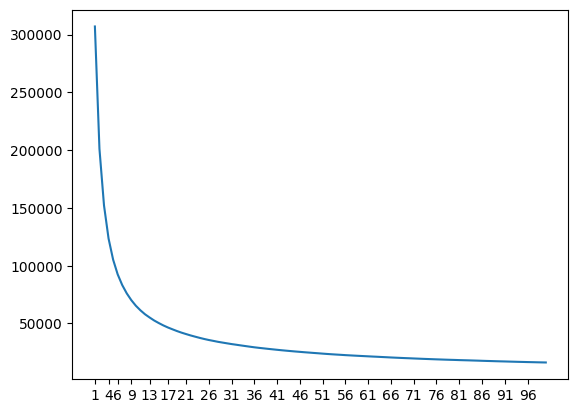

In [8]:
plt.plot(data[0], data[1])
plt.xticks([1, 4, 6, 9, 13, 17] + list(range(21, 101, 5)))
plt.show()

По правилу плеча было решено попробовать удалить непопулярные слова с минимальной абсолютной частотой меньше 13

In [11]:
counter_wo_13 = {k: v for k, v in counter.items() if v > 13}

print(f'{len(counter_wo_13)}/{len(counter)} осталось термов')

55222/794959 осталось термов


Затем были удалены различные слова (стоп-слова). В частности взят за основу список стоп-слов (https://gist.github.com/ethen8181/d57e762f81aa643744c2ffba5688d33a) из объединения nltk.corpus.stopwords и sklearn.feature_extraction.stop_words. Соответственно, выдвигается гипотеза, что рассматриваемые тексты близкие к обычным текстам уровня википедии и т.д., а также включают в себя "обычный" (без какого-либо смещения из-за предметной области) список стоп-слов

In [12]:
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
# ENGLISH_STOP_WORDS = set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS) )

ENGLISH_STOP_WORDS = set([
    'a',
    'about',
    'above',
    'across',
    'after',
    'afterwards',
    'again',
    'against',
    'ain',
    'all',
    'almost',
    'alone',
    'along',
    'already',
    'also',
    'although',
    'always',
    'am',
    'among',
    'amongst',
    'amoungst',
    'amount',
    'an',
    'and',
    'another',
    'any',
    'anyhow',
    'anyone',
    'anything',
    'anyway',
    'anywhere',
    'are',
    'aren',
    'around',
    'as',
    'at',
    'back',
    'be',
    'became',
    'because',
    'become',
    'becomes',
    'becoming',
    'been',
    'before',
    'beforehand',
    'behind',
    'being',
    'below',
    'beside',
    'besides',
    'between',
    'beyond',
    'bill',
    'both',
    'bottom',
    'but',
    'by',
    'call',
    'can',
    'cannot',
    'cant',
    'co',
    'con',
    'could',
    'couldn',
    'couldnt',
    'cry',
    'd',
    'de',
    'describe',
    'detail',
    'did',
    'didn',
    'do',
    'does',
    'doesn',
    'doing',
    'don',
    'done',
    'down',
    'due',
    'during',
    'each',
    'eg',
    'eight',
    'either',
    'eleven',
    'else',
    'elsewhere',
    'empty',
    'enough',
    'etc',
    'even',
    'ever',
    'every',
    'everyone',
    'everything',
    'everywhere',
    'except',
    'few',
    'fifteen',
    'fify',
    'fill',
    'find',
    'fire',
    'first',
    'five',
    'for',
    'former',
    'formerly',
    'forty',
    'found',
    'four',
    'from',
    'front',
    'full',
    'further',
    'get',
    'give',
    'go',
    'had',
    'hadn',
    'has',
    'hasn',
    'hasnt',
    'have',
    'haven',
    'having',
    'he',
    'hence',
    'her',
    'here',
    'hereafter',
    'hereby',
    'herein',
    'hereupon',
    'hers',
    'herself',
    'him',
    'himself',
    'his',
    'how',
    'however',
    'hundred',
    'i',
    'ie',
    'if',
    'in',
    'inc',
    'indeed',
    'interest',
    'into',
    'is',
    'isn',
    'it',
    'its',
    'itself',
    'just',
    'keep',
    'last',
    'latter',
    'latterly',
    'least',
    'less',
    'll',
    'ltd',
    'm',
    'ma',
    'made',
    'many',
    'may',
    'me',
    'meanwhile',
    'might',
    'mightn',
    'mill',
    'mine',
    'more',
    'moreover',
    'most',
    'mostly',
    'move',
    'much',
    'must',
    'mustn',
    'my',
    'myself',
    'name',
    'namely',
    'needn',
    'neither',
    'never',
    'nevertheless',
    'next',
    'nine',
    'no',
    'nobody',
    'none',
    'noone',
    'nor',
    'not',
    'nothing',
    'now',
    'nowhere',
    'o',
    'of',
    'off',
    'often',
    'on',
    'once',
    'one',
    'only',
    'onto',
    'or',
    'other',
    'others',
    'otherwise',
    'our',
    'ours',
    'ourselves',
    'out',
    'over',
    'own',
    'part',
    'per',
    'perhaps',
    'please',
    'put',
    'rather',
    're',
    's',
    'same',
    'see',
    'seem',
    'seemed',
    'seeming',
    'seems',
    'serious',
    'several',
    'shan',
    'she',
    'should',
    'shouldn',
    'show',
    'side',
    'since',
    'sincere',
    'six',
    'sixty',
    'so',
    'some',
    'somehow',
    'someone',
    'something',
    'sometime',
    'sometimes',
    'somewhere',
    'still',
    'such',
    'system',
    't',
    'take',
    'ten',
    'than',
    'that',
    'the',
    'their',
    'theirs',
    'them',
    'themselves',
    'then',
    'thence',
    'there',
    'thereafter',
    'thereby',
    'therefore',
    'therein',
    'thereupon',
    'these',
    'they',
    'thick',
    'thin',
    'third',
    'this',
    'those',
    'though',
    'three',
    'through',
    'throughout',
    'thru',
    'thus',
    'to',
    'together',
    'too',
    'top',
    'toward',
    'towards',
    'twelve',
    'twenty',
    'two',
    'un',
    'under',
    'until',
    'up',
    'upon',
    'us',
    've',
    'very',
    'via',
    'was',
    'wasn',
    'we',
    'well',
    'were',
    'weren',
    'what',
    'whatever',
    'when',
    'whence',
    'whenever',
    'where',
    'whereafter',
    'whereas',
    'whereby',
    'wherein',
    'whereupon',
    'wherever',
    'whether',
    'which',
    'while',
    'whither',
    'who',
    'whoever',
    'whole',
    'whom',
    'whose',
    'why',
    'will',
    'with',
    'within',
    'without',
    'won',
    'would',
    'wouldn',
    'y',
    'yet',
    'you',
    'your',
    'yours',
    'yourself',
    'yourselves'
])

In [15]:
counter_wo_13_wo_stopword_1 = {k: v for k, v in counter_wo_13.items() if k not in ENGLISH_STOP_WORDS}

print(f'{len(counter_wo_13_wo_stopword_1)}/{len(counter_wo_13)} осталось термов')

54900/55222 осталось термов


Далее список оставшихся слов был почищен от различных спец. символово, цифр и прочего, в том числе включая банальное ручное удаление слов с помощью сортировки и выделения ненужных слов.

Итоговым получился словарь из 51780 слов. Для работы улучшения качества, оптимизации памяти и времени работы, конечно, желательно сжимать такое пространство или, по крайней мере, использовать разреженные матрицы, но пока цель - сделать простой baseline для тематического моделирования текстов (желательно, с минимумом зависимостей и временных/ресурсных затрат).

In [17]:
PATH_VOCABULARY = 'ordered_vocabulary.json'

with open(PATH_VOCABULARY, 'r', encoding='utf-8') as fio:
    vocabulary = json.load(fio)
    
print(f'{len(vocabulary)}/{len(counter_wo_13_wo_stopword_1)} осталось термов')

51780/54900 осталось термов


In [ ]:
Пишем свой векторайзер для online обучения

In [25]:
class CountVectorizerTopicModel:
    """Count vectorizer for Topic Modeling (using LDA)"""

    def __init__(self, path_to_vocabulary: str = PATH_VOCABULARY):
        """
        Init CountVectorizerTopicModel
        
        :param path_to_vocabulary: path to vocabulary with excpected words
        """
        
        self.path_to_vocabulary = path_to_vocabulary

        with open(self.path_to_vocabulary, 'r', encoding='utf-8') as fio:
            self.vocabulary: dict = json.load(fio)
            self.collect_vocabulary: list = list(self.vocabulary.keys())  # for python 3.6+
            self.n_vocabulary = len(self.vocabulary)

        self.regex_spec_symbol = re.compile(r'[\.\,\?\!\(\)\/\$\{\}\[\]\@\^]+')
        self.regex_spec_symbol_to_space = re.compile(r'[\“\"\']+')
        self.regex_multi_space_to_space = re.compile(r'\s+')

    def transform(self, collect_text) -> np.ndarray:
        """
        Transform to 2D-numpy matrix

        :param collect_text: list of texts

        :return: numpy matrix where each row is vector of one text
        """

        n_text = len(collect_text)

        array = np.full((n_text, self.n_vocabulary), 0)

        for i, text in enumerate(collect_text):
            collect_word = text.split()

            for j in map(self.word_to_index, collect_word):
                if j is not None:
                    array[i, j] += 1

        return array

    def word_to_index(self, word: str, default=None) -> int:
        """
        Get index of vocabulary for this word

        :param word: raw word
        :param default: default for vocabulary

        :return: index in vocabulary
        """
        
        preprocess_word = self.preprocess_word(word)

        return self.vocabulary.get(preprocess_word, default)

    def preprocess_word(self, word: str) -> str:
        """
        Preprocess word

        :param word: word

        :return: cleaning word
        """

        word_new = self.regex_spec_symbol.sub('', word.lower())
        word_new = self.regex_spec_symbol_to_space.sub(' ', word_new)
        word_new = self.regex_multi_space_to_space.sub(' ', word_new)

        return word_new

А теперь пробуем обучать LDA и смотреть, что будет. 
В том числе производится вычисление перплексии для текущего батча текстов

In [ ]:
# модель сохраняется на каждом этапе дообучения
#   1. памяти требуется немного
#   2. времени требуется немного

# перед запуском должна быть папка "model_{N_COMPONENTS}"

N_COMPONENTS = 30
PATH_TO_SAVE_MODEL = f'model_{N_COMPONENTS}'

# lda = LDA(n_components=N_COMPONENTS)
lda = LDA(n_components=N_COMPONENTS, learning_method='online', max_iter=20, n_jobs=2)

vectorizer = CountVectorizerTopicModel()

print(
    f'N_COMPONENTS={N_COMPONENTS}\n',
    f'PATH_TO_SAVE_MODEL={PATH_TO_SAVE_MODEL}\n',
    '\n',
    f'LDA: {LDA}\n',
    '\n'
    f'vectorizer: {vectorizer}\n',
    f'number of vocabulary:: {len(vectorizer.vocabulary)}\n',
    f'vocabulary: {vectorizer.collect_vocabulary[:50]}...'
)

N_BATCH = 10_000
i = 0
with open(PATH_CLEAN_DATA, 'r', encoding='utf-8') as fio:

    batch = []
    for line in tqdm(fio):
        i += 1

        dict_line = ujson.loads(line)
        batch.append(dict_line['text'])

        if len(batch) == N_BATCH:
            number_lda = i // N_BATCH
            print(f'iter batch: {number_lda}')

            print('partial fit start')
            t1 = timeit.default_timer()
            batch_numpy = vectorizer.transform(batch)
            lda.partial_fit(batch_numpy)
            print(f'partial fit start with time: {round((timeit.default_timer() - t1) / 60, 4)}')

            batch_perplexity = lda.perplexity(batch_numpy)
            print(f'batch perplexity: {round(batch_perplexity, 4)}')

            del batch_numpy
            batch = []

            with open(f'{PATH_TO_SAVE_MODEL}/lda_{number_lda}.sav', 'wb') as fio:
                pickle.dump(lda, fio)


Перплексия ожидаемо уменьшается при итерация дообучения. 

Также стоит отметить, что перплексия хуже по показателям при увеличении числа топиков/тем.

Поэтому следующим этапом было посмотреть получившиеся топики по топ-N словам и принять решение о выборе лучшего числа топиков
из имеющихся обученных моделей

По итогу обучения на разном количестве топиков получились следующие тематики (через топ-10 слов) для корпуса текстов:

5 топиков:

    0 topic: image, using, method, images, model, data, based, detection, recognition, analysis
    1 topic: data, system, model, information, approach, systems, based, learning, process, using
    2 topic: algorithm, problem, method, algorithms, results, proposed, new, number, based, set
    3 topic: network, system, performance, networks, control, systems, data, proposed, design, based
    4 topic: research, study, information, social, technology, computer, development, use, users, new

8 топиков:

    0 topic: fuzzy, genetic, theory, g, functions, set, i, p, c, function
    1 topic: proposed, method, based, performance, using, results, model, scheme, algorithm, control
    2 topic: system, data, network, networks, systems, information, design, applications, based, web
    3 topic: software, development, process, research, design, knowledge, engineering, systems, business, project
    4 topic: model, data, approach, models, using, based, language, used, system, analysis
    5 topic: video, learning, study, social, human, information, use, not, computer, robot
    6 topic: image, images, using, visual, segmentation, surface, features, color, motion, spectrum
    7 topic: algorithm, problem, algorithms, number, problems, time, optimal, linear, method, graph

10 топиков:

    0 topic: mobile, data, system, network, transmission, analysis, testing, results, test, reliability
    1 topic: information, search, rules, language, programs, retrieval, web, using, text, not
    2 topic: system, systems, data, design, model, architecture, approach, using, framework, based
    3 topic: image, using, method, images, recognition, based, motion, video, detection, rate
    4 topic: algorithm, proposed, performance, method, results, problem, based, time, algorithms, model
    5 topic: model, data, learning, models, approach, analysis, results, methods, knowledge, based
    6 topic: network, networks, service, user, system, users, services, information, wireless, communication
    7 topic: graph, problem, graphs, set, number, all, finite, given, k, class
    8 topic: classification, et, spectral, entropy, smaller, al, false, binding, des, trained
    9 topic: software, research, development, design, technology, process, computer, systems, study, business
    
20 топиков:

    0 topic: research, systems, design, computer, analysis, software, development, modeling, engineering, methods
    1 topic: method, proposed, results, based, image, using, model, algorithm, methods, approach
    2 topic: i, g, codes, matrix, k, p, m, c, s, trees
    3 topic: language, programming, optimal, logic, semantic, program, programs, constraints, tree, semantics
    4 topic: design, system, systems, software, architecture, applications, performance, video, distributed, service
    5 topic: kernel, consensus, radar, analyse, kernels, für, lies, im, des, zur
    6 topic: grid, cluster, spectral, actual, clusters, lines, et, proteins, wiley, interpolation
    7 topic: control, cell, system, relations, transformation, base, functional, particle, diagnosis, treatment
    8 topic: model, system, models, approach, systems, knowledge, study, process, information, how
    9 topic: network, networks, mobile, wireless, performance, system, channel, sensor, security, access
    10 topic: web, users, social, online, content, digital, students, game, people, information
    11 topic: learning, classification, fuzzy, clustering, robot, training, based, machine, constraint, performance
    12 topic: dynamic, product, capacity, when, shows, fault, reliability, region, strategies, sharing
    13 topic: scheme, function, linear, method, optimization, parameters, solution, results, schemes, functions
    14 topic: motion, rules, tracking, surface, mapping, rule, human, mean, resolution, fundamental
    15 topic: information, management, business, decision, process, quality, planning, policy, service, technology
    16 topic: detection, recognition, neural, using, images, system, visual, speech, segmentation, genetic
    17 topic: power, study, energy, effect, effects, activity, numerical, imaging, frequency, camera
    18 topic: data, information, search, features, large, not, database, algorithms, used, approach
    19 topic: problem, algorithm, graph, number, time, complexity, graphs, problems, class, scheduling

30 топиков:

    0 topic: object, objects, surface, points, measurement, configuration, geometric, map, field, force
    1 topic: graph, number, set, graphs, class, k, bound, given, all, bounds
    2 topic: learning, classification, selection, clustering, robot, training, task, multiple, evaluation, set
    3 topic: numerical, distance, coding, point, computation, differential, translation, ii, vectors, boundary
    4 topic: mobile, data, channel, sensor, access, system, traffic, network, query, transmission
    5 topic: programming, language, functions, logic, routing, rules, languages, mapping, rule, automated
    6 topic: function, matrix, signal, tracking, filter, convergence, noise, nonlinear, estimation, signals
    7 topic: not, how, when, one, time, out, there, do, what, work
    8 topic: network, control, scheme, systems, simulation, fuzzy, neural, model, proposed, based
    9 topic: networks, problem, time, nodes, protocol, optimal, tree, generalized, probability, solution
    10 topic: maintenance, navigation, radar, für, im, usa, zur, des, eine, modifying
    11 topic: video, motion, feedback, virtual, cache, activity, vehicle, frame, switching, movement
    12 topic: image, images, using, features, recognition, feature, visual, detection, based, segmentation
    13 topic: power, study, base, consumption, risk, production, supply, rendering, demand, technology
    14 topic: search, database, web, sequence, retrieval, flow, information, sequences, text, document
    15 topic: model, models, representation, finite, theory, framework, structure, set, types, using
    16 topic: system, design, systems, approach, software, used, using, user, implementation, application
    17 topic: performance, service, wireless, applications, distributed, services, architecture, web, computing, environment
    18 topic: security, reliability, mean, attacks, detection, privacy, secure, failure, trust, recovery
    19 topic: rate, energy, parameters, system, phase, reduction, sensing, spectrum, using, interference
    20 topic: computer, science, survey, research, years, researchers, scientific, area, computers, technical
    21 topic: artificial, human, media, spectral, intelligence, lines, internet, material, mass, peer-to-peer
    22 topic: data, memory, patterns, computational, analysis, pattern, mining, prediction, genetic, identification
    23 topic: information, research, development, knowledge, systems, study, process, software, support, use
    24 topic: algorithm, method, proposed, results, based, performance, approach, using, algorithms, problem
    25 topic: results, behavior, analysis, modeling, context, different, factors, link, effects, cognitive
    26 topic: medical, message, cluster, diagnosis, clusters, cancer, dependence, skills, negotiation, breast
    27 topic: speech, influence, constant, line, input, edge, previously, recognition, clinical, cells
    28 topic: codes, c, p, s, i, b, t, d, word, x
    29 topic: online, students, group, electronic, health, market, university, research, course, education
    
40 топиков:

    0 topic: service, services, computing, virtual, environments, resource, applications, environment, resources, grid
    1 topic: recognition, code, semantic, real-time, hardware, speech, system, interactive, weighted, improves
    2 topic: network, networks, mobile, wireless, sensor, nodes, communication, traffic, transmission, node
    3 topic: system, systems, control, design, model, based, programming, using, process, used
    4 topic: approach, problem, problems, optimization, local, constraints, solutions, global, reduction, methods
    5 topic: field, fields, visualization, navigation, body, visual, right, hand, induced, trained
    6 topic: spectrum, rate, transfer, chain, stage, supply, production, diversity, market, population
    7 topic: performance, high, parallel, results, power, number, memory, large, proposed, data
    8 topic: data, information, database, analysis, using, patterns, decision, mining, used, study
    9 topic: use, support, systems, information, design, approach, management, study, architecture, technology
    10 topic: robot, evaluation, measures, policy, assessment, policies, operator, operators, trust, integer
    11 topic: software, distributed, internet, tasks, management, ontology, server, development, remote, system
    12 topic: video, motion, online, visual, embedded, suitable, game, games, optical, media
    13 topic: human, hybrid, dynamics, control, robots, force, particle, target, physical, quantum
    14 topic: frequency, evaluating, active, voltage, cmos, separation, compensation, q, assembly, passive
    15 topic: strategy, feedback, agents, activity, states, produce, treatment, learned, privacy, monitor
    16 topic: time, design, simulation, delay, path, fault, errors, circuit, measurement, computer
    17 topic: study, tracking, effects, effect, cluster, clusters, significantly, diffusion, response, factor
    18 topic: learning, time, system, optimal, solution, problem, cost, planning, location, documents
    19 topic: engineering, research, science, ieee, technology, university, fusion, industrial, education, scientific
    20 topic: space, estimation, solution, procedure, parameter, state, function, considered, kernel, density
    21 topic: knowledge, research, computer, how, process, different, development, work, role, important
    22 topic: classification, problem, functions, class, function, theory, optimal, finite, results, general
    23 topic: text, students, elements, natural, experience, light, language, true, material, report
    24 topic: graph, algorithm, graphs, algorithms, number, set, problem, tree, k, all
    25 topic: digital, social, interaction, business, collaborative, message, modelling, people, international, public
    26 topic: scheme, schemes, numerical, adaptive, signal, matrix, nonlinear, generalized, stability, polynomial
    27 topic: neural, spatial, results, segmentation, distribution, energy, phase, time, using, analysis
    28 topic: genetic, sequence, cell, sequences, prediction, protein, expression, gene, brain, normal
    29 topic: i, distance, c, p, s, compute, b, t, m, d
    30 topic: security, channel, scheduling, query, queries, protocols, access, protocol, key, systems
    31 topic: test, not, value, testing, values, when, cases, domains, do, one
    32 topic: web, user, search, users, information, retrieval, content, interface, group, sharing
    33 topic: logic, language, type, coding, semantics, formal, extended, verification, properties, abstract
    34 topic: points, point, surface, convergence, line, iterative, geometric, configuration, mesh, spectral
    35 topic: codes, length, et, reliable, al, convex, connected, questions, la, page
    36 topic: analyse, für, des, im, ber, zur, eine, sa, auf, tracker
    37 topic: image, images, features, using, feature, method, object, objects, approach, based
    38 topic: algorithm, method, proposed, based, using, algorithms, methods, detection, results, fuzzy
    39 topic: model, models, representation, structure, modeling, structures, framework, partial, probabilistic, equations
    
50 топиков:

    0 topic: code, social, traditional, sources, crucial, qualitative, movement, popular, rfid, personal
    1 topic: security, phase, key, not, mean, cloud, attacks, secure, failure, actions
    2 topic: für, im, des, ber, zur, twitter, eine, csi, auf, als
    3 topic: digital, required, frequency, sensing, spectrum, radio, stage, voltage, current, rate
    4 topic: algorithm, networks, algorithms, mobile, time, memory, complexity, efficient, scheduling, number
    5 topic: method, image, using, algorithm, images, proposed, based, feature, features, object
    6 topic: modeling, test, testing, length, convex, regular, smart, graphics, la, designs
    7 topic: online, specific, field, product, embedded, suitable, fields, domains, events, ieee
    8 topic: group, series, capacity, collaborative, artificial, media, privacy, intelligence, collaboration, participants
    9 topic: decision, multimedia, joint, adaptation, characteristics, criteria, population, consensus, speaker, transactions
    10 topic: cases, effects, filter, active, simulation, region, response, scenarios, shows, visualization
    11 topic: detection, estimation, matrix, transmission, signals, ontology, regression, kernel, gaussian, iterative
    12 topic: problem, optimal, solution, algorithm, solutions, solve, planning, location, cost, identify
    13 topic: recognition, speech, human, system, face, previously, word, words, body, false
    14 topic: optimization, energy, global, efficiency, modelling, event, reliable, coverage, connected, true
    15 topic: graph, graphs, set, number, k, maximum, edge, family, there, vertices
    16 topic: process, study, management, technology, business, processes, impact, production, requirements, risk
    17 topic: effect, cell, particle, past, transport, swarm, disease, treatment, revealed, laboratory
    18 topic: method, results, linear, time, using, accuracy, error, when, rate, value
    19 topic: system, design, systems, architecture, applications, implementation, application, parallel, distributed, hardware
    20 topic: medical, chain, diagnosis, molecular, quantum, soft, dna, degrees, mechanical, chemical
    21 topic: nonlinear, schemes, stability, stochastic, properties, differential, conditions, discrete, interference, finite
    22 topic: class, input, source, reliability, base, classes, brain, representations, array, maps
    23 topic: power, consumption, factor, low, cache, switching, diffusion, compared, efficiency, secondary
    24 topic: learning, training, influence, environment, unit, education, teaching, items, customer, educational
    25 topic: computer, research, computing, science, communications, survey, international, years, scientific, article
    26 topic: i, c, p, m, s, g, b, t, d, x
    27 topic: information, knowledge, use, how, systems, not, research, support, context, design
    28 topic: classification, numerical, machine, coding, vector, operations, computation, variables, variable, reference
    29 topic: data, analysis, approach, different, methods, used, techniques, multiple, based, results
    30 topic: integration, vision, market, cooperative, competitive, equilibrium, cooperation, price, private, artifacts
    31 topic: state, behavior, genetic, strategies, attention, gene, expression, normal, cells, genes
    32 topic: functions, function, generalized, game, polynomial, sets, given, trees, general, finite
    33 topic: control, neural, signal, controller, adaptive, network, action, orthogonal, inputs, contact
    34 topic: simulation, program, components, programs, component, execution, transformation, heuristic, system, functional
    35 topic: experiments, fault, cluster, equation, clusters, optical, noise, responses, variance, frequent
    36 topic: space, size, total, storage, points, block, expected, large, scale, number
    37 topic: dynamic, real-time, mechanism, surface, convergence, motion, dynamics, using, device, high
    38 topic: video, visual, feedback, elements, measurement, sensors, sensor, frame, display, position
    39 topic: language, logic, type, rules, properties, extended, semantics, formal, verification, languages
    40 topic: problems, fuzzy, approach, theory, constraints, framework, based, programming, new, systems
    41 topic: web, user, search, users, services, information, system, content, retrieval, interface
    42 topic: semantic, query, tree, tracking, reduction, queries, activity, states, index, processing
    43 topic: model, models, representation, structure, using, probabilistic, parameters, difference, computational, used
    44 topic: text, students, volume, course, report, update, pages, overview, law, instruction
    45 topic: network, communication, wireless, channel, protocol, distributed, traffic, routing, system, access
    46 topic: data, performance, database, using, selection, resource, prediction, evaluate, environments, results
    47 topic: service, quality, electronic, constant, demand, delivery, maintenance, assignment, patients, relay
    48 topic: proposed, scheme, performance, based, task, results, strategy, compared, evaluation, hybrid
    49 topic: software, development, engineering, project, measures, documents, tools, internet, open, projects

При детальном рассмотрении выходит, что повышении количества тематик начинается увеличваться количество похожих тематик
(т.е. которые можно было бы свести в один класс/топик), при этом также увеличивается количество тематик, которым сложно
присвоить какое-то логичное описание или как-то характеризовать данный топик (т.е. он некий unknown)

При этом при уменьшении мы сталкиваемся со слиянием нескольких топиков, что ухудшит будущую поисковую выдачу

На данный момент было принято решение остановиться на количестве топиков N = 20 с присвоением определённого типа топика, имени класса, описывающего его. Эти данные были сформированы на основе топ-10 слов (и далее будут вручную частично проверены через просмотр статей). Ниже приведены сами имена для каждого топика, предварительно сохранённые в файл index_topic_to_name_topic.json:

In [31]:
PATH_INDEX_TO_NAME_TOPIC = 'index_topic_to_name_topic.json'

with open(PATH_INDEX_TO_NAME_TOPIC, 'r', encoding='utf-8') as fio:
    index_to_name_topic = json.load(fio)
    
pprint(list(index_to_name_topic.values()))

['machine learning / research',
 'machine learning / approach',
 'unknown',
 'nlp',
 'system design',
 'germany radar / unknown',
 'clustering',
 'medicine',
 'unknown',
 'networks',
 'social network / digital / web',
 'fuzzy logic / robot',
 'unknown',
 'optimization',
 'detection / computer vision',
 'business analyse',
 'computer vision',
 'industrial',
 'search',
 'graph']


А также написана класс-обёртка для всего pipeline-а предсказания топика:

In [32]:
class TopicModelPipeline:

    def __init__(self,
                 path_to_lda: str,
                 path_to_vocabulary: str,
                 path_to_index_name_topic: str):
        """
        Init TopicModelPipeline:

        :param path_to_lda: path to pickle file of LatentDirichletAllocation
        :param path_to_vocabulary: path to vocabulary
        :param path_to_index_name_topic: path to index topic to topic name
        """

        self.path_to_lda = path_to_lda
        self.path_to_vocabulary = path_to_vocabulary
        self.path_index_topic_to_name_topic = path_to_index_name_topic

        self.vectorizer = CountVectorizerTopicModel(path_to_vocabulary)

        with open(path_to_lda, 'rb') as fio:
            self.lda: LDA = pickle.load(fio)

        with open(path_to_index_name_topic, 'r', encoding='utf-8') as fio:
            self.index_topic_to_name_topic = {
                int(k): v
                for k, v in json.load(fio).items()
            }

    def predict(self, collect_text: list) -> list:
        """
        Get list of topic for list of text

        :param collect_text: list of text

        :return: list of topic
        """

        batch_numpy = self.vectorizer.transform(collect_text)
        batch_predict = self.lda.transform(batch_numpy)
        batch_top_index = np.argsort(batch_predict, axis=1)[:, -1]

        name_topic = [self.index_topic_to_name_topic[top_i] for top_i in batch_top_index]

        return name_topic

In [34]:
PATH_LDA = 'lda_topic_20.sav'

topic_model = TopicModelPipeline(
    PATH_LDA,
    PATH_VOCABULARY,
    PATH_INDEX_TO_NAME_TOPIC
)

print(topic_model.predict(['medicine diagnosis treatment',
                           'Article about new method to do it']))

['medicine', 'machine learning / approach']
